# Hide your messy video background using neural nets, Part 2
> "Using our trained model to blur the background of video frames with OpenCV."

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [fastai, privacy, opencv]
- image: images/articles/2021-backgroundblur-2/thumbnail.jpg
- hide: false

In [25]:
#hide
!pip install fastai==2.2.5 opencv-python==4.5.1.48 -q

In [26]:
#hide
from fastai.vision.all import *
import cv2
import pdb

## Load Learner

The `Learner` expects to find all functions that were defined when creating it, in our case that is `create_mask`. We don't need any custom functionality however, so we define an empty `create_mask` function.

In [27]:
def create_mask(): pass

Load the `learner` we exported in Part 1:

In [28]:
learn = load_learner('export.pkl')

## Practicing Predictions

> Note: You can skip this part and jump to the [OpenCV part](#Constructing-the-Image-With-Blurred-Background). I included this section because I wanted to see and show the different outputs of the `predict` function.

Let's pick a random file from our training images to practice getting the model predictions: 

In [29]:
fnames = get_image_files('training')
image = fnames[0]

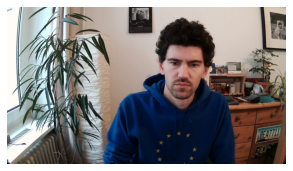

In [107]:
PILImage.create(image).show();

Get predictions of one training image:

In [31]:
preds = learn.predict(image)

In [32]:
#collapse_output
preds

(TensorMask([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 TensorImage([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 TensorImage([[[9.9910e-01, 9.9987e-01, 9.9999e-01,  ..., 9.9790e-01,
           9.8746e-01, 9.4114e-01],
          [9.9981e-01, 9.9999e-01, 1.0000e+00,  ..., 9.9982e-01,
           9.9790e-01, 9.7789e-01],
          [9.9979e-01, 1.0000e+00, 1.0000e+00,  ..., 9.9998e-01,
           9.9973e-01, 9.9559e-01],
          ...,
          [7.8446e-01, 8.4830e-01, 8.4362e-01,  ..., 9.9416e-01,
           9.8244e-01, 9.3761e-01],
          [7.0075e-01, 7.4211e-01, 7.1380e-01,  ..., 9.8295e-01,
           9.6359e-01, 9.0397e-01],
          [6.7

There are different tensors in the predictions. `preds[0]` contains the output after `argmax`, so it picks the class with the higher probability. Every pixel is either a `0` or a `1` in line with our two classes.

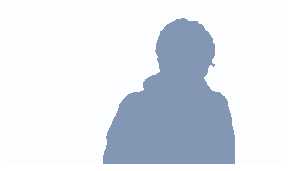

In [33]:
preds[0].show(cmap='Blues', vmin=0, vmax=1);

In [34]:
#collapse
print(f'''unique values: {np.unique(preds[0])}
         type: {type(preds[0])}
    data type: {preds[0].dtype}''')

unique values: [0 1]
         type: <class 'fastai.torch_core.TensorMask'>
    data type: torch.int64


`preds[1]` contains the same values, just in a different type (`TensorImage` instead of `TensorMask`)

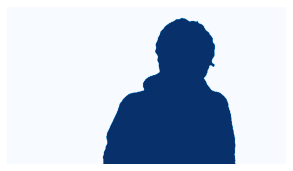

In [35]:
preds[1].show(cmap='Blues', vmin=0, vmax=1);

In [36]:
#collapse
print(f'''unique values: {np.unique(preds[1])}
         type: {type(preds[1])}
    data type: {preds[1].dtype}''')

unique values: [0 1]
         type: <class 'fastai.torch_core.TensorImage'>
    data type: torch.int64


`preds[2]` is a tensor with three dimensions. It contains the probabilities of the two classes as float values.

In [37]:
preds[2].shape

(2, 360, 640)

In [38]:
#collapse
print(f'''unique values: {np.unique(preds[2])}
         type: {type(preds[2])}
    data type: {preds[2].dtype}''')

unique values: [4.5733633e-14 4.8081161e-14 5.0750907e-14 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
         type: <class 'fastai.torch_core.TensorImage'>
    data type: torch.float32


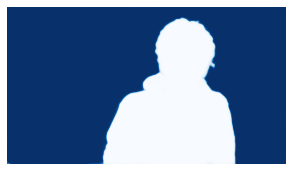

In [39]:
preds[2][0].show(cmap='Blues');

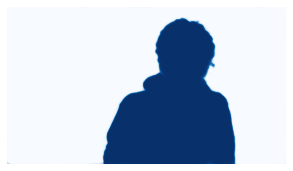

In [40]:
preds[2][1].show(cmap='Blues');

## Constructing the Image With Blurred Background

We could use `preds[1]` with just `0`s and `1`s for a simple mask. I tried that initially and it worked, it resulted in some rough edges however.

Instead, we will use `preds[2][1]` since it is a little smoother. You can try for yourself which one you like btter.

Let's define a simple blur function.

In [42]:
def blur(img: np.ndarray, kernel_size=5, sigma_x=0) -> np.ndarray:
    # Make sure that kernel size is an odd number
    if kernel_size % 2 == 0:
        kernel_size += 1
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma_x)

We now define a function that blurs the background and blends in the original frame with an alpha mask. Thank you to [learnopencv.com](https://learnopencv.com/alpha-blending-using-opencv-cpp-python/) for their useful code!

In [81]:
def masked_blur(image: np.ndarray, mask: TensorImage) -> np.ndarray:
    "mask must have dimensions (360,640)"
    foreground = cv2.resize(image, (640,360), interpolation=cv2.INTER_AREA)
    background = blur(foreground, kernel_size=61)

    # Convert uint8 to float
    foreground = foreground.astype(np.float32)
    background = background.astype(np.float32)
    
    # Some transforms to match the dimensions and type of the cv2 image
    alpha = to_np(mask.unsqueeze(2).repeat(1,1,3)).astype(np.float32)

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)

    # Add the masked foreground and background.
    result = cv2.add(foreground, background)
    
    return result

Read in an image, predict the mask

In [89]:
frame = cv2.imread(str(image))
frame = cv2.resize(frame, (640,360), interpolation=cv2.INTER_AREA)

In [90]:
frame.shape

(360, 640, 3)

In [116]:
t = torch.tensor(np.ascontiguousarray(np.flip(frame, 2)).transpose(2,0,1))
t_img = to_image(t)

In [118]:
preds = learn.predict(t_img)
preds[1]

AssertionError: Expected an input of type in 
  - <class 'pathlib.PosixPath'>
  - <class 'pathlib.Path'>
  - <class 'str'>
  - <class 'torch.Tensor'>
  - <class 'numpy.ndarray'>
  - <class 'bytes'>
  - <class 'fastai.vision.core.PILImage'>
 but got <class 'PIL.Image.Image'>

In [77]:
frame = cv2.imread(str(image))
preds = learn.predict(image)
alpha = preds[2][1]

Create the resulting image and have a look:

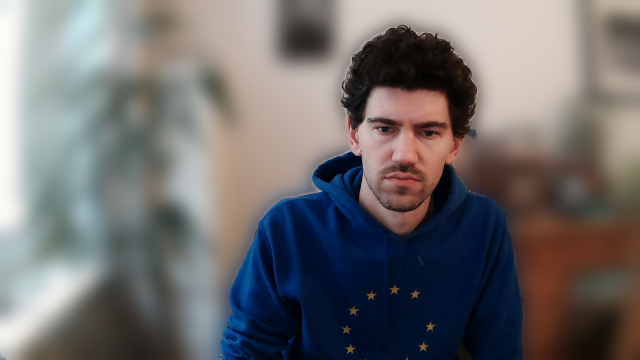

In [82]:
output = masked_blur(frame, alpha)
cv2.imwrite('output/alpharesult.png', output)
PILImage.create('output/alpharesult.png')

Apart from my grumpy look, I think this is a quite good result!

## Capture Video

As for now, we just work with a saved video file. To work with live webcam video, we would have to increase the speed of the inference process by a lot. On my current Paperspace Gradient machine (P4000) it runs at about 0.5 FPS....

Setting up video files. `testclip.mp4` is a video I shot with my webcam. The arguments for the `VideoWriter` are framerate and dimensions. I chose 25 because I think this is the framerate of my webcam, and 640x360 are the dimensions we used to train the neural net.

In [47]:
cap = cv2.VideoCapture('testclip.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/blurred-testclip-smooth.mp4', fourcc, 25, (640, 360))

## Main Loop

We use this while loop to capture every frame of the video. For every frame we
1. Resize it to 640x360
2. Save it to disk
3. Use the model to predict the mask
4. Create the image with blurred background
5. Write this image to the output video
6. Remove the original frame from disk.

Additionally, we save some frames as `jpg` files to inspect them.

In [74]:
i = 0
while cap.isOpened():
    # Capture frame
    ret, frame = cap.read()
    
    # Break loop at end of video
    if ret == False:
        break
    
    # Resize frame and save to disk
    frame = cv2.resize(frame, (640,360), interpolation=cv2.INTER_AREA)
    cv2.imwrite('output/frame_'+str(i)+'.jpg',frame)       
    
    # Run inference and create alpha mask from result
    preds = learn.predict('output/frame_'+str(i)+'.jpg') 
    mask = preds[2][1]
    
    # Blur background and convert it to integer type
    output = masked_blur(frame, mask).astype(np.uint8)
    
    # Write frame to video
    out.write(output)
    
    # Save every 25th output as jpg, just to find a good thumbnail :)
    if i == 0 or i%25 == 0:
        cv2.imwrite('output/smooth_output_'+str(i)+'.jpg', output) 
    
    # Remove saved frame
    os.remove('output/frame_'+str(i)+'.jpg')

    # Increase counter
    i += 1
    
# Release opened files
cap.release()
out.release()

## Results

Let's look at a single frame:

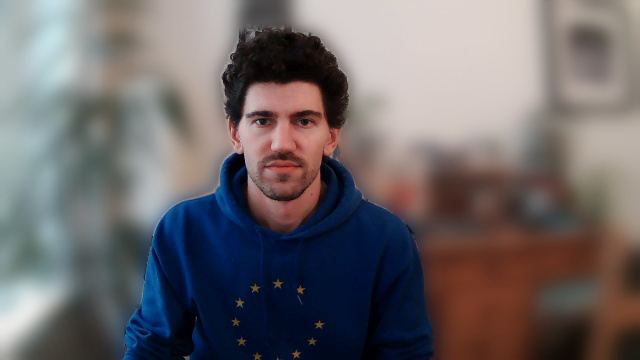

In [75]:
PILImage.create('output/smooth_output_0.jpg')

And the resulting video:

<video width="640" height="360" autoplay>
  <source src="../../tree/blurry-background/output/smooth.mp4" type="video/mp4">
  <!--<source src="./output/smooth.webm" type="video/webm">-->
Your browser does not support the video tag.
</video> 

This looks pretty good! There are some rough edges and my arms are not recognized well, but overall I'm happy with the result for this little project.

## To Do

There are many aspects which we could improve:

- The biggest thing to improve now is inference speed. As I mentioned, the current implementation works only with video files, not live video, and it runs at about 0.5 frames per second 🥴 The U-Net is a pretty heavy model, even with the relatively small Resnet18 backbone. The saved weights are 167MB. This alone is reason enough for the model to run slow. Since we run the model frame by frame, the GPU is not helping much because there is no parallelization.

- The current implementation is also inconvenient because it relies on opening an image file from disk. The model should be able to run on an opened image (= numpy array) directly.

- The next step would be better generalization. I suspect that this model is currently very much optimized for myself. If we wanted to roll this out as a feature for many people, we would have to include many people and different backgrounds, cameras, and lightning situations.

Let me know when you found this helpful or implemented something similar yourself, I'd be happy to hear from you on [Twitter](https://twitter.com/daflowjoe)!